# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts
from pref_bootstrap import priors

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 5.315088 (||params||=4.529731, ||grad||=7.516669, ||E[dr/dw]||=6.595050)
INFO:root:Occupancy measure error@iter  100: 0.032026 (||params||=5.148026, ||grad||=0.045291, ||E[dr/dw]||=7.028660)
INFO:root:Occupancy measure error@iter  200: 0.006486 (||params||=5.021163, ||grad||=0.009173, ||E[dr/dw]||=7.007284)


In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.     1.0823 0.    ]
 [0.     0.     6.9177 0.    ]
 [0.     0.     0.     0.    ]]

Recovered state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.     1.0813 0.    ]
 [0.     0.     6.9187 0.    ]
 [0.     0.     0.     0.    ]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)

In [7]:
print('Log likelihood (IRL):', float(irl_feedback_model.log_likelihood(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. reward params (IRL):\n', np.asarray(irl_feedback_model.log_likelihood_grad_rew(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. bias params (IRL):\n', irl_feedback_model.log_likelihood_grad_bias(irl_dataset, rmodel, irl_bias_params))

Log likelihood (IRL): -15.008544921875
Gradient w.r.t. reward params (IRL):
 [ 0.      0.      0.      0.      0.      0.     -3.2627  0.      0.      0.      1.811   0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (IRL):
 [ 0.      0.      0.      0.      0.      0.     -4.9493  0.      0.      0.      1.3061  0.
  0.      0.      0.      0.    ]


## Another example with the paired comparison learner

In [8]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(10)

In [9]:
print('Log likelihood (PC):', float(pc_feedback_model.log_likelihood(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. reward params (PC):\n', np.asarray(pc_feedback_model.log_likelihood_grad_rew(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. bias params (PC):\n', pc_feedback_model.log_likelihood_grad_bias(comparison_dataset, rmodel, pc_bias_params))

Log likelihood (PC): -1.1641980409622192
Gradient w.r.t. reward params (PC):
 [ 0.      0.      0.      0.      0.      0.     -0.8552  0.      0.      0.      0.8552  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (PC):
 -1.0048702


## Putting it all together

Now we can create a combined demo in which we use both MCE IRL and paired comparisons to learn a reward model and set of modality-specific bias models.

Ideas for ergonomic improvements:

- Incorporate reward priors on the `RewardModel` class, just as we have for bias priors and `EnvFeedbackModel`.
- Make parameter storage consistent between reward models and feedback models. Either feedback models should store parameters (instead of keeping them external), or reward models should keep parameters external (instead of storing them as class attributes).

In [10]:
# TODO(sam): try finding a step size with backtracking line search, rather
# than using a fixed step. Also consider using a Nesterov step.
def joint_training(env, feedback_models, all_names, all_datasets,
                   all_bias_params, rmodel, rprior, init_step_size=1e-3,
                   n_steps=100):
    """Jointly trains a single reward model and a set of feedback bias models
    on a given environment. Trains reward model with gradient descent, and
    individual bias models with projected gradient descent.

    Args:
        env (gym.Environment): environment to train on.
        feedback_models ([EnvFeedbackModel]): list of environment feedback
            models.
        all_names ([str]): human-readable names for the feedback models, to
            be used for logging (`all_names[i]` is the name for
            `feedback_models[i]`).
        all_datasets (list): list of datasets for the feedback models
            (`all_datasets[i]` is the dataset for `feedback_models[i]`).
        all_bias_params (list): list of bias parameters for feedback models.
            (`all_bias_params[i]` contains bias parameters for
            `feedback_models[i]`).
        rmodel (RewardModel): reward model, assumed to be shared across all
            feedback modalities.
        rprior (Prior): prior on reward model parameters.
        init_step_size (float): length of the first step. Step size scales
            linearly down to (just above) zero over the course of training.
        n_steps (int): total number of steps to take.
        
    Returns: tuple of `(rmodel, all_bias_params)`, where `rmodel` is the same
        model passed into the functino (this is updated in-place), and
        `all_bias_params` is a set of updated bias parameters (these are not
        updated in-place)."""
    assert len(feedback_models) == len(all_datasets)
    assert len(feedback_models) == len(all_bias_params)
    all_bias_params = list(all_bias_params)
    
    def compute_ll():
        """Compute log likelihood of data under current reward model, bias
        params, etc."""
        ll_terms = [
            ('rmodel_prior', rprior.log_prior(rmodel.get_params())),
        ]
        name_model_ds_bias_iter = zip(
            all_names, feedback_models, all_datasets, all_bias_params)
        for name, model, dataset, bias_params in name_model_ds_bias_iter:
            ll = model.log_likelihood(dataset, rmodel, bias_params)
            ll_terms.append((f'{name}', ll))
            ll_terms.append((f'{name}_prior', model.bias_prior.log_prior(bias_params)))
        total_ll = sum(ll for name, ll in ll_terms)
        return_dict = dict(ll_terms)
        return_dict['all_terms'] = total_ll
        return return_dict

    ll_history = {k: [v] for k, v in compute_ll().items()}

    for step_num in range(n_steps):
        # progress_10 is 1 at the start of training, and linear drops to
        # (just above) 0 at the end (after n_steps)
        progress_10 = 1 - step_num / n_steps
        step_size = init_step_size * progress_10 

        # first do a joint reward model update w/ plain gradient descent
        rmodel_grad = np.zeros_like(rmodel.get_params())
        model_ds_bias_iter = zip(feedback_models, all_datasets, all_bias_params)
        for model, dataset, bias_params in model_ds_bias_iter:
            rmodel_grad += model.log_likelihood_grad_rew(
                dataset, rmodel, bias_params)
        rmodel_grad += rprior.log_prior_grad(rmodel.get_params())
        rmodel.set_params(rmodel.get_params() + step_size * rmodel_grad)

        # now do individual bias model updates
        model_ds_bias_enum = enumerate(zip(
            feedback_models, all_datasets, all_bias_params))
        for model_idx, (model, dataset, bias_params) in model_ds_bias_enum:
            # Projected gradient descent: we take a gradient descent step, then
            # project back to the support of the prior.
            bias_param_grad = model.log_likelihood_grad_bias(
                dataset, rmodel, bias_params)
            bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
            bias_grad = bias_param_grad + bias_prior_grad
            unproj_step = all_bias_params[model_idx] + step_size * bias_grad
            proj_step = model.bias_prior.project_to_support(bias_grad)
            all_bias_params[model_idx] = proj_step

            for k, v in compute_ll().items():
                ll_history[k].append(v)

    return rmodel, all_bias_params, ll_history

In [11]:
jt_names = ['blind_irl', 'paired_comparisons']
jt_feedback_models = [irl_feedback_model, pc_feedback_model]
jt_datasets = [irl_dataset, comparison_dataset]
rng, jt_irl_feedback_params = irl_feedback_model.init_bias_params(rng)
rng, jt_pc_bias_params = pc_feedback_model.init_bias_params(rng)
jt_bias_params = [jt_irl_feedback_params, jt_pc_bias_params]
jt_rmodel = r_models.LinearRewardModel(env.obs_dim)
jt_rprior = priors.FixedGaussianPrior(
    mean=0.0, std=1.0, shape=rmodel.get_params().shape)
jt_rmodel, jt_bias_params, ll_history = joint_training(
    env=env, feedback_models=jt_feedback_models, all_names=jt_names,
    all_datasets=jt_datasets, all_bias_params=jt_bias_params,
    rmodel=jt_rmodel, rprior=jt_rprior, init_step_size=1e-3, n_steps=100)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


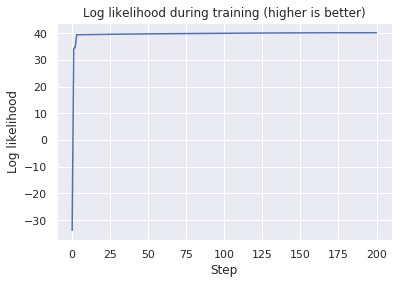

In [12]:
# plotting just the total log likelihood
loss_values = ll_history['all_terms']
plt.plot(np.arange(len(loss_values)), loss_values)
plt.xlabel('Step')
plt.ylabel('Log likelihood')
plt.title('Log likelihood during training (higher is better)')
plt.show()

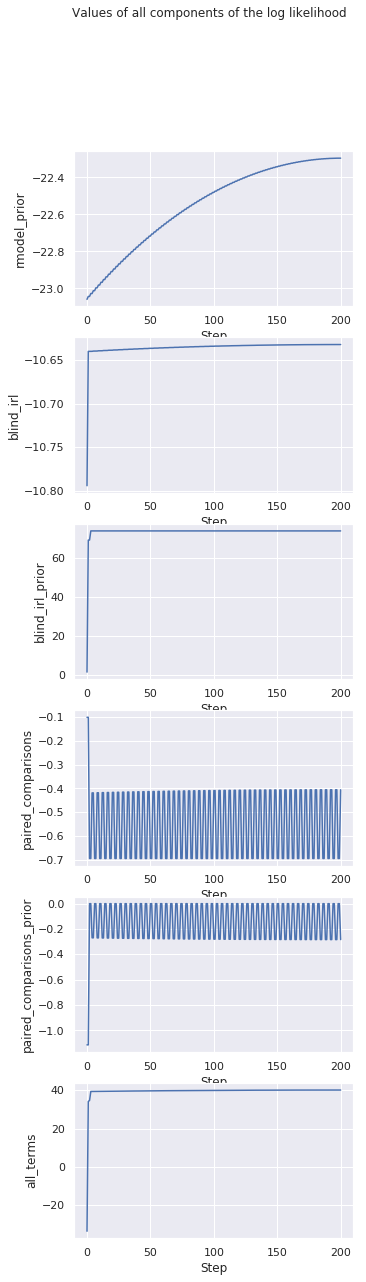

In [13]:
# plotting all terms in the log likelihood
plt.figure(figsize=(5, 20))
all_hist_items = list(ll_history.items())
for idx, (plot_name, plot_values) in enumerate(all_hist_items):
    plt.subplot(len(all_hist_items), 1, idx + 1)
    plt.plot(np.arange(len(plot_values)), plot_values)
    plt.xlabel('Step')
    plt.ylabel(plot_name)
plt.suptitle('Values of all components of the log likelihood')
plt.show()

In [17]:
np.array([int(True), int(False)])*np.array([1, 2])

array([1, 0])